# BreastMammaryTissueJunctionAnalysis as a Notebook 

rMATS 3.2.5 was run on controlled access RNASeq files retrieved experiments stored in the Sequence Read Archive with controlled access managed by dbGaP.   The data were generated under the Gene Tissue Expression.

## rMATS RNASeq-MATS.py produces 10 different output types which get assembled into as type junction ID by sample ID matrices

### Alternative Splice Site Types are: (se, a3ss, a5ss, mxe, ri)

 This is input as ARGV1 into variable 'astype'

  * Skipped Exon events (se),
  * Alternative 3' splice site (a3ss),
  * Alternative 5' splice site (a5ss),
  * Mutually exclusive exon (mxe),
  * and retention intron (ri)

### There are two different kinds of junction counts

  * jc = junction counts - reads that cross the junction
  * jcec = junction counts plus reads on the target (such as included exon

### And the count type -- there are 5 types

  * inclusion levels (percent spliced in)
  * included junction counts (ijc)
  * skipped junction counts (sjc)
  * inclusion length (inclen)
  * skipped length (skiplen)

### function: fit_iso_tissue 

fit_iso_tissue expects the following input:

  * the tissue of interest (SMSTD) 
  * an ordered_merged_rmats -- which will be ordered to fit the count matrix
  * count matrix (inc or ijc & sjc merged)
  * splice type (a3ss, a5ss, mxe, ri or se)
  * junction_count type (jc or jcec)
  * count type (inc or the merged ijc,sjc)
  
### reordering to match annotations between count matrix and annotation matrix

Common problem is to match specifically the rows of an annotation matrix with the columns of a count matrix
`match` is the function that gives the re-ordering index required to accomplish this


## **NOTE**:

We assume that you have cloned the analysis repository and have `cd` into the parent directory. Before starting with the analysis make sure you have first completed the dependencies set up by following the instructions described in the **`dependencies/README.md`** document. All paths defined in this Notebook are relative to the parent directory (repository). Please close this Notebook and start again by following the above guidelines if you have not completed the aforementioned steps.

## rMATS-final-merged
the rmats-nf NextFlow was executed and the results released here:

## Loading dependencies

In [1]:
library(limma)
library(multtest)
library(Biobase)
library(edgeR)
library(tibble)
install.packages('R.utils')
library(R.utils)

Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:limma’:

    plotMA

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome to Bio

## Modeling

This analysis uses edgeR.  From the documentation, it is important to note that normalization takes the form of correction factors that enter into the statistical model. Such correction factors are usually computed internally by edgeR functions, but it is also possible for a user to supply them. The correction factors may take the form of scaling factors for the library sizes, such as computed by calcNormFactors, which are then used to compute the effective library sizes. 

Alternatively, gene-specific correction factors can be entered into the glm functions of edgeR as offsets. In the latter case, the offset matrix will be assumed to account for all normalization issues, including sequencing depth and RNA composition.

Note that normalization in edgeR is model-based, and the original read counts are not themselves transformed. This means that users should not transform the read counts in any way before inputing them to edgeR. For example, users should not enter RPKM or FPKM val- ues to edgeR in place of read counts. Such quantities will prevent edgeR from correctly estimating the mean-variance relationship in the data, which is a crucial to the statistical strategies underlying edgeR. Similarly, users should not add artificial values to the counts before inputing them to edgeR.

edgeR is not designed to work with estimated expression levels, for example as might be output by Cufflinks. 
edgeR can work with expected counts as output by RSEM, but raw counts are still preferred. 

As instructed by the software, we are using the raw counts as provided by rMATS.  The raw counts we are using in the model are `ijc` and `sjc`, the sample specific raw read counts as they align to the junctions of the `included exon (ijc)` and the junctions of the `excluded or skipped exon (sjc)` respectively.



In [2]:
ijc.iso.counts.mem <- data.table::fread("../data/rmats_final.se.jc.ijc.txt.gz") 
sjc.iso.counts.mem <- data.table::fread("../data/rmats_final.se.jc.sjc.txt.gz") 
inc.iso.counts.mem <- data.table::fread("../data/rmats_final.se.jc.inc.txt.gz")

meta.data<-read.csv('../data/SraRunTable.noCram.noExome.noWGS.totalRNA.txt',header=TRUE, stringsAsFactors=FALSE)
head(ijc.iso.counts.mem)
head(sjc.iso.counts.mem)
head(inc.iso.counts.mem)
head(meta.data)

ID,SRR1068788,SRR1068808,SRR1068832,SRR1068855,SRR1068880,SRR1068929,SRR1068953,SRR1068977,SRR1068999,⋯,SRR821573,SRR821581,SRR821602,SRR821626,SRR821653,SRR821690,SRR821715,SRR823967,SRR823991,SRR824015
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,1,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,26,247,103,620,494,145,145,139,697,⋯,151,32,62,48,963,25,196,76,72,61
3,1,0,1,0,0,0,1,1,2,⋯,2,1,0,1,3,0,1,0,0,0
4,0,1,1,2,0,0,1,0,2,⋯,0,0,0,0,1,0,0,0,0,0
5,3,0,2,3,6,1,1,1,5,⋯,3,2,0,1,6,0,2,0,0,0
6,2,1,2,5,6,1,1,0,5,⋯,1,1,0,0,4,0,1,0,0,0


ID,SRR1068788,SRR1068808,SRR1068832,SRR1068855,SRR1068880,SRR1068929,SRR1068953,SRR1068977,SRR1068999,⋯,SRR821573,SRR821581,SRR821602,SRR821626,SRR821653,SRR821690,SRR821715,SRR823967,SRR823991,SRR824015
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,2,0,1,3,6,1,0,0,3,⋯,1,1,0,0,3,0,1,0,0,0
2,0,0,0,1,0,0,1,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,1,⋯,0,0,0,0,2,0,1,0,0,0
5,0,5,3,8,4,0,3,0,3,⋯,9,3,1,2,3,0,1,0,1,0
6,11,119,36,284,207,60,63,43,295,⋯,52,13,14,9,338,8,63,25,20,18


ID,SRR1068788,SRR1068808,SRR1068832,SRR1068855,SRR1068880,SRR1068929,SRR1068953,SRR1068977,SRR1068999,⋯,SRR821573,SRR821581,SRR821602,SRR821626,SRR821653,SRR821690,SRR821715,SRR823967,SRR823991,SRR824015
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0.0000,0.0000,0.000,0.0000,0.0769,0.0000,0.0000,0,0.0000,⋯,0.0000,0.000,0,0.0,0.0000,0,0.0000,0,0,0
2,1.0000,1.0000,1.000,0.9972,1.0000,1.0000,0.9885,1,1.0000,⋯,1.0000,1.000,1,1.0,1.0000,1,1.0000,1,1,1
3,1.0000,0.0000,1.000,0.0000,0.0000,0.0000,1.0000,1,1.0000,⋯,1.0000,1.000,0,1.0,1.0000,0,1.0000,0,0,0
4,0.0000,1.0000,1.000,0.5000,0.0000,0.0000,1.0000,0,0.5000,⋯,0.0000,0.000,0,0.0,0.2000,0,0.0000,0,0,0
5,1.0000,0.0000,0.250,0.1578,0.4285,1.0000,0.1428,1,0.4545,⋯,0.1428,0.250,0,0.2,0.5000,0,0.5000,0,0,0
6,0.0833,0.0041,0.027,0.0087,0.0142,0.0082,0.0078,0,0.0084,⋯,0.0095,0.037,0,0.0,0.0058,0,0.0078,0,0,0


,Run,analyte_type,Assay.Type,AvgSpotLen,Bases,BioProject,BioSample,biospecimen_repository,biospecimen_repository_sample_id,body_site,⋯,data_type..run.,product_part_number..exp.,product_part_number..run.,sample_barcode..exp.,sample_barcode..run.,is_technical_control,target_set..exp.,primary_disease..exp.,secondary_accessions..run.,Alignment_Provider..run.
,<chr>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<chr>,<chr>,<lgl>
1,SRR2911715,RNA,RNA-Seq,150,3852895500,PRJNA244100,SAMN04216864,Cloud Testing,HG00103,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
2,SRR2911716,RNA,RNA-Seq,150,4885577400,PRJNA244100,SAMN04216866,Cloud Testing,HG00154,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
3,SRR2911718,RNA,RNA-Seq,150,2690545500,PRJNA244100,SAMN04216863,Cloud Testing,NA18910,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
4,SRR2911719,RNA,RNA-Seq,150,2699599350,PRJNA244100,SAMN04216865,Cloud Testing,NA19200,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
5,SRR2911720,RNA,RNA-Seq,152,4300467752,PRJNA244100,SAMN04216865,Cloud Testing,NA19200,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA
6,SRR2911717,RNA,RNA-Seq,150,2666546700,PRJNA244100,SAMN04216863,Cloud Testing,NA18910,Lymphoblastoid cell line,⋯,,,,NA,NA,,NA,,,NA


## Synchronize metadata samples with ijc, sjc and inc samples

Keep only the runs that are in the ijc count list (assuming ijc and sjc are the same).  As well, name the rows with the junction id column and then make the matrix just about the counts.

In [3]:
#dimensions before we make the changes.
dim(ijc.iso.counts.mem)
dim(sjc.iso.counts.mem)
dim(inc.iso.counts.mem)
dim(meta.data)

# the sample names are in the columns of both the ijc and the sjc matrices, these matrices have the identical column order)
keep.meta.data <- meta.data$Run %in% colnames(ijc.iso.counts.mem)
table(keep.meta.data)
reduced.meta.data <- meta.data[keep.meta.data==TRUE,]

[1] 42611  8674

[1] 42611  8674

[1] 42611  8674

[1] 9784   79

keep.meta.data
FALSE  TRUE 
 1111  8673 

## Construct the ijc, sjc and inc as data matrices
The Junction ID is encoded in the first column of the matrix.  We need to both preserve it (and it is unique) as well as remove it so we may do our calculations.

In [4]:
# preserve junction id as rowname
rownames(ijc.iso.counts.mem) <- ijc.iso.counts.mem$ID
rownames(sjc.iso.counts.mem) <- sjc.iso.counts.mem$ID
rownames(inc.iso.counts.mem) <- inc.iso.counts.mem$ID

# and remove the id to have a data matrix
ijc.iso.counts.mem  <- ijc.iso.counts.mem[,-1]
sjc.iso.counts.mem  <- sjc.iso.counts.mem[,-1]
inc.iso.counts.mem  <- inc.iso.counts.mem[,-1]
dim(ijc.iso.counts.mem)
dim(sjc.iso.counts.mem)
dim(inc.iso.counts.mem)
dim(reduced.meta.data)

[1] 42611  8673

[1] 42611  8673

[1] 42611  8673

[1] 8673   79

## Order ijc and sjc columns in the same order as the metadata Run order

Using tibble library, we can rearrange the columns as the column name.  

In [5]:
meta.data.run.names  <- as.character(reduced.meta.data$Run)
ijc.iso.counts.mem2  <- as_tibble(ijc.iso.counts.mem)
sjc.iso.counts.mem2  <- as_tibble(sjc.iso.counts.mem)
inc.iso.counts.mem2  <- as_tibble(inc.iso.counts.mem)

ijc.iso.counts.mem2  <- ijc.iso.counts.mem2[,c(meta.data.run.names)]
sjc.iso.counts.mem2  <- sjc.iso.counts.mem2[,c(meta.data.run.names)]
inc.iso.counts.mem2  <- inc.iso.counts.mem2[,c(meta.data.run.names)]

Remove samples that match '11IL0' from the ijc, sjc and metadata files

In [6]:
keep.meta.data <- (!grepl('11ILO',reduced.meta.data$Sample.Name))
table(keep.meta.data)
ijc.iso.counts.mem2 <-ijc.iso.counts.mem2 [                    ,keep.meta.data==TRUE]
sjc.iso.counts.mem2 <-sjc.iso.counts.mem2 [                    ,keep.meta.data==TRUE]
inc.iso.counts.mem2 <-inc.iso.counts.mem2 [                    ,keep.meta.data==TRUE]
reduced.meta.data   <-reduced.meta.data   [keep.meta.data==TRUE,                    ]
dim(ijc.iso.counts.mem2)
dim(sjc.iso.counts.mem2)
dim(inc.iso.counts.mem2)

keep.meta.data
FALSE  TRUE 
   12  8661 

[1] 42611  8661

[1] 42611  8661

[1] 42611  8661

### and focus on a single tissue

this will become a function so we can proceed on all the tissues

In [7]:
tissue <- reduced.meta.data$body_site %in% 'Breast - Mammary Tissue'
table(tissue)

ijc.iso.counts.mem2 <-ijc.iso.counts.mem2 [                    ,tissue==TRUE]
sjc.iso.counts.mem2 <-sjc.iso.counts.mem2 [                    ,tissue==TRUE]
inc.iso.counts.mem2 <-inc.iso.counts.mem2 [                    ,tissue==TRUE]
reduced.meta.data   <-reduced.meta.data   [tissue==TRUE,                    ]
dim(ijc.iso.counts.mem2)
dim(sjc.iso.counts.mem2)
dim(inc.iso.counts.mem2)

tissue
FALSE  TRUE 
 8470   191 

[1] 42611   191

[1] 42611   191

[1] 42611   191

### exploration of the details

For each sample, we have ijc and sjc count data and demographics of gender.
Our question is regarding the sex biased differences.
For each junction we have 8,000 samples with these count data.   The way to think about the model is that we have in fact for all of these junctions, these are our co-variates in this global transcriptomic model. 
For exon skipping events (SE), we have 42,611 non-zero junction IDs the (first dimension of the ijc and sjc cout table) for the skipped exon event for breast-Mammary Tissue, 191 individuals.  These are healthy individuals, and we are studying the impact of sex on the occurrence or non-occurance of specific alternative splicing events.   We explore the information we ahve about these junctions and create a construct, as_event, which accounts for the junction under exploration.

In [8]:
ijc      <- as.data.frame(ijc.iso.counts.mem2)
sjc      <- as.data.frame(sjc.iso.counts.mem2)
ijc      <- data.matrix(ijc)
sjc      <- data.matrix(sjc)


## Exploring the ijc and sjc Count data 

We have two counts that are in many ways two sides of the same coin.  Both our the observational output and we wish to see how robust each are in their ability to separate out the samples to provide for us differentially expressed isoform events as measured by their counts.   Each junction is in a manner a specific marker to specific isoform events that may or may not be shared between the genders.   If there is significant results, then this is indicative of the separation achieved by isoform specific differentiation.   In our model we will use these in combination, it is important to see if they will yield the results we are looking for.

### IJC

Exon included junction counts -- duplicate correlation is actually 2 (there are 2 exons for each included exon) the results provide robust separation up until around 550.  Also important to filter low expression counts

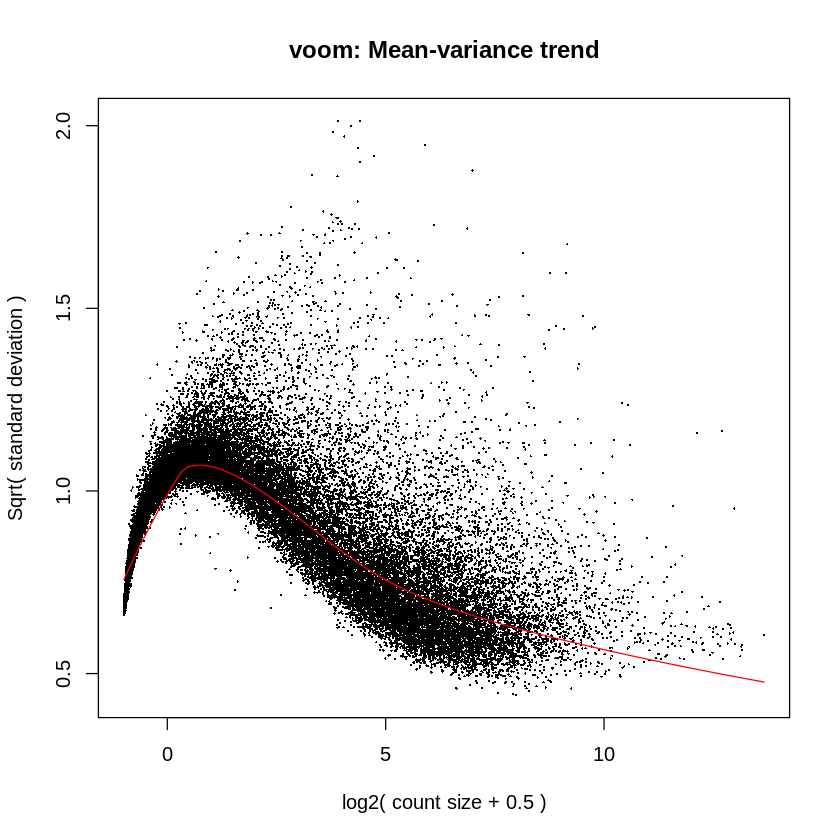

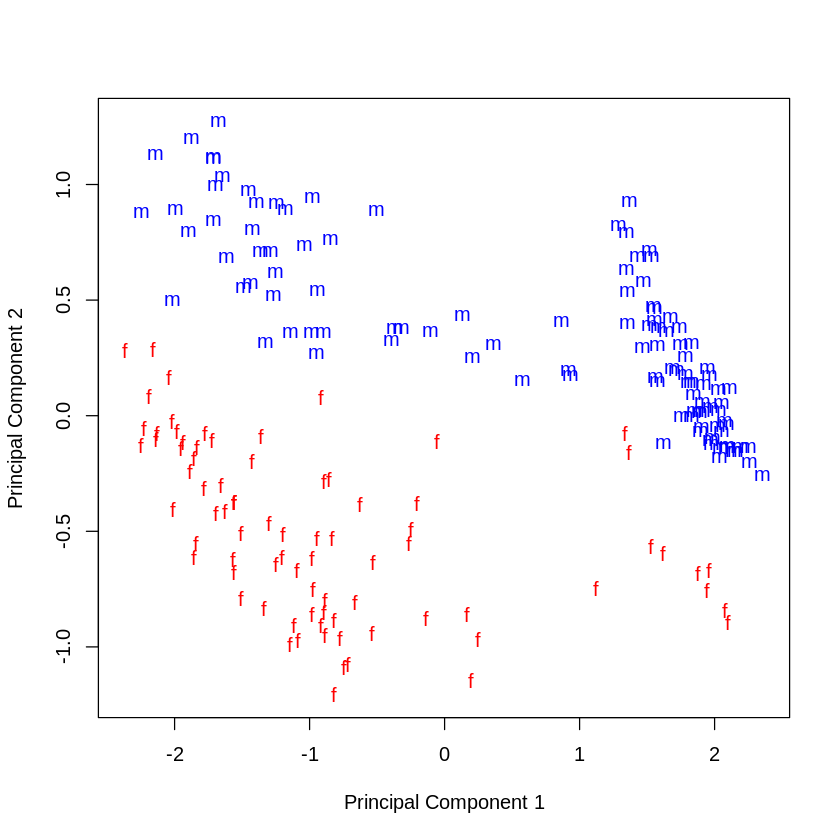

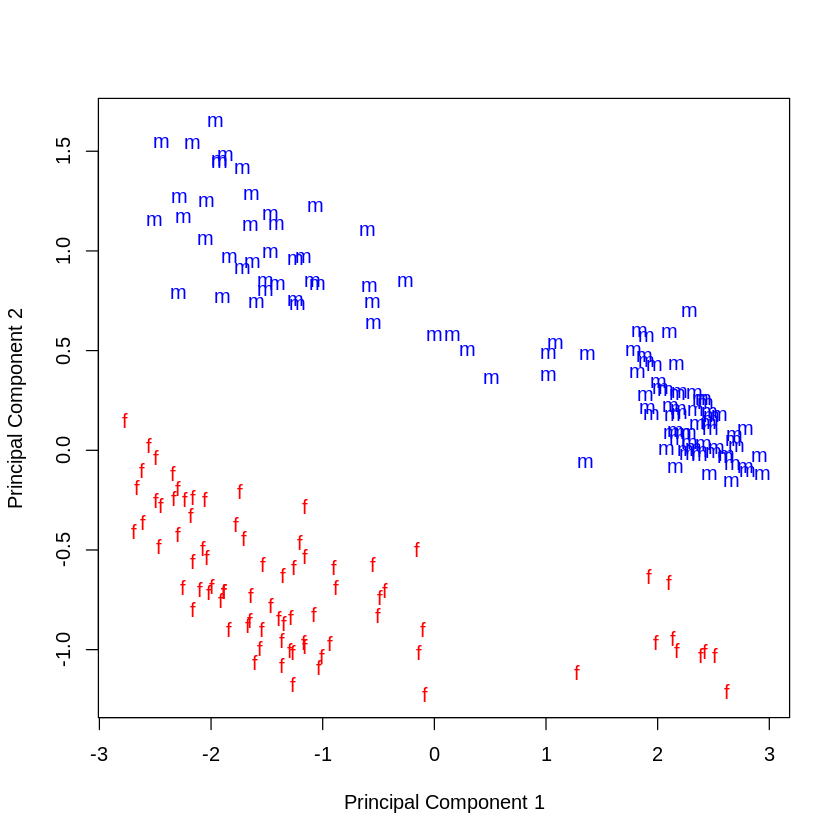

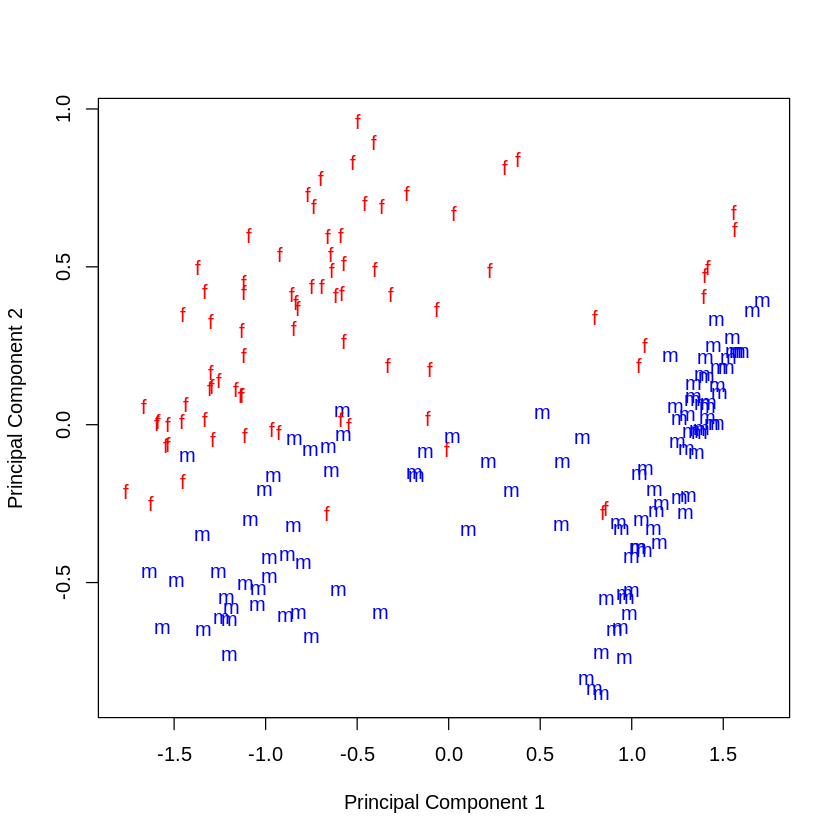

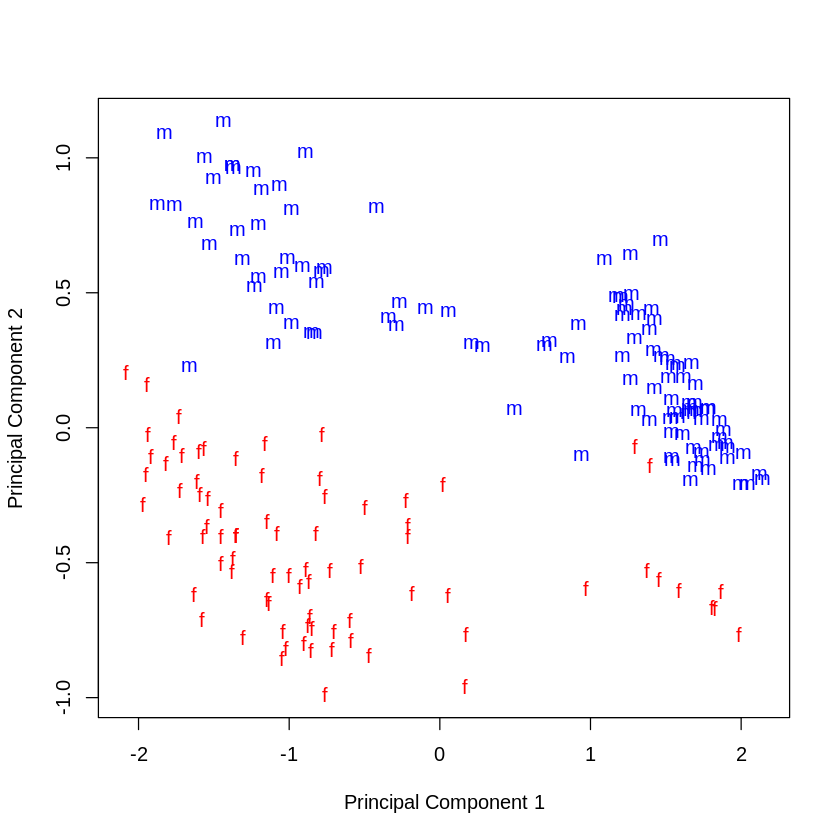

In [9]:
sex       <- factor(reduced.meta.data$sex,levels=c('male','female'))

design    <- model.matrix ( ~ sex)
y <- DGEList(counts=ijc, group = sex)
y <- calcNormFactors(y, method="upperquartile")

sex       <- factor(reduced.meta.data$sex,levels=c('male','female'))

design    <- model.matrix ( ~ sex)

y_voom <- voom (y, design=design, plot=TRUE )

Gender <- substring(sex,1,1)

plotMDS(y, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y_voom, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y, labels=Gender, top=1500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y_voom, labels=Gender, top=1500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")


### IJC Plots saved as PDFs

In [10]:
pdf("../pdf/BreastMammaryTissue_ijc_voom.pdf")
y_voom <- voom (y, design=design, plot = TRUE, save.plot = TRUE)
dev.off()

Gender <- substring(sex,1,1)

pdf("../pdf/BreastMammaryTissue_ijc_MDSplot_top500.pdf")
plotMDS(y, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
dev.off()

pdf("../pdf/BreastMammaryTissue_ijc_voom_MDSplot_top500.pdf")
plotMDS(y_voom, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
dev.off()

pdf("../pdf/BreastMammaryTissue_ijc_MDSplot_top1500.pdf")
plotMDS(y, labels=Gender, top=1500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
dev.off()

pdf("../pdf/BreastMammaryTissue_ijc_voom_MDSplot_top1500.pdf")
plotMDS(y_voom, labels=Gender, top=1500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
dev.off()



png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

### SJC
sjc counts are skipped exon junction counts -- ijc counts hold together for the top 1000, the skipped exon junction counts fall appart
at a lower number -- around 200!  separation fails between the genders at 250

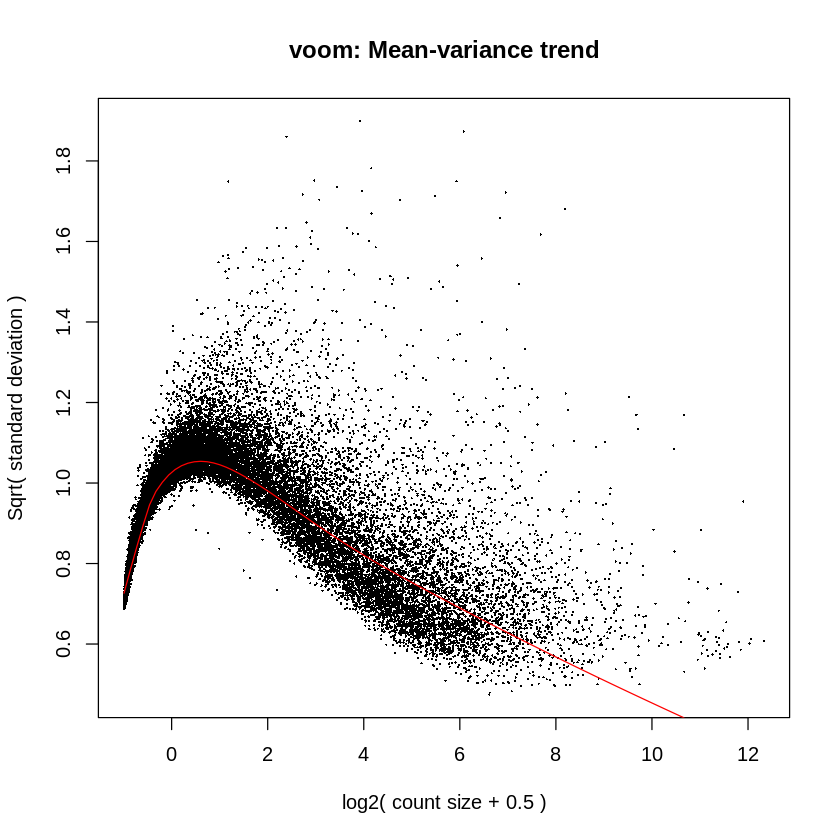

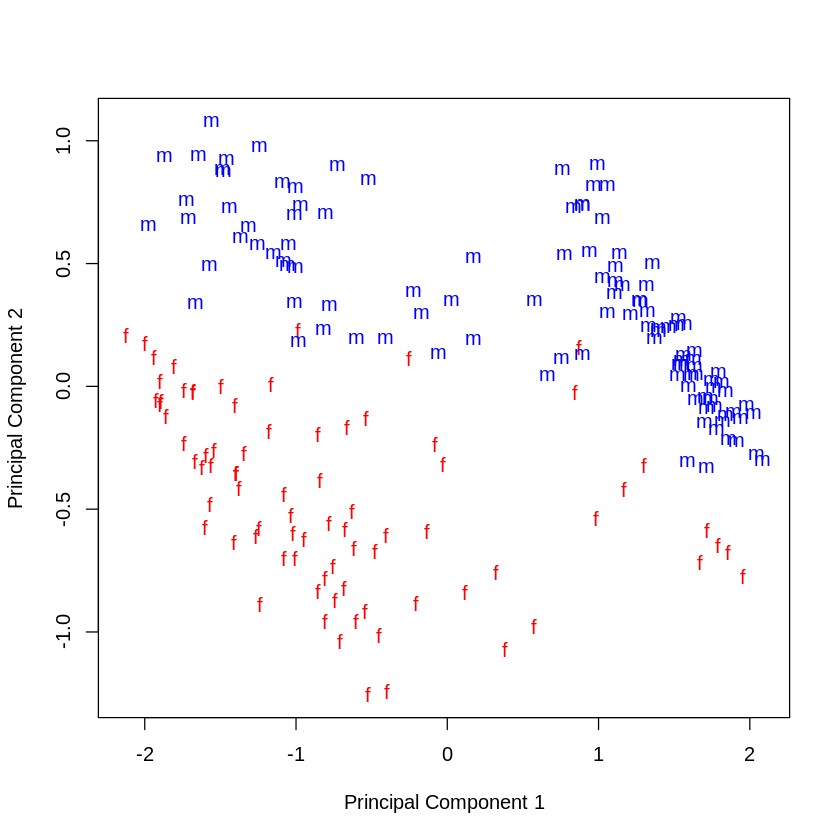

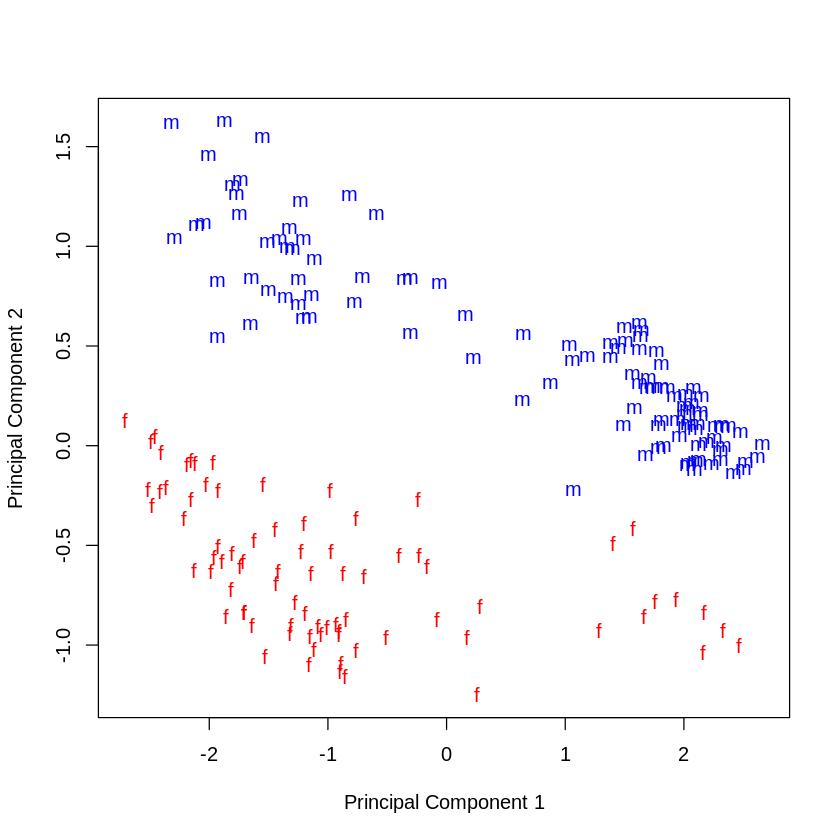

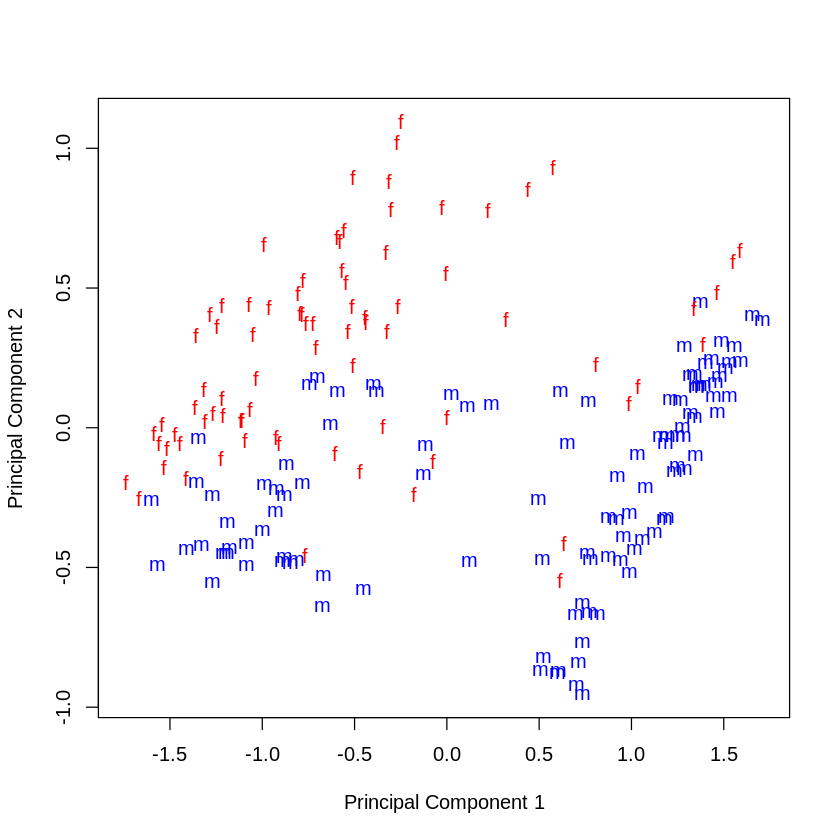

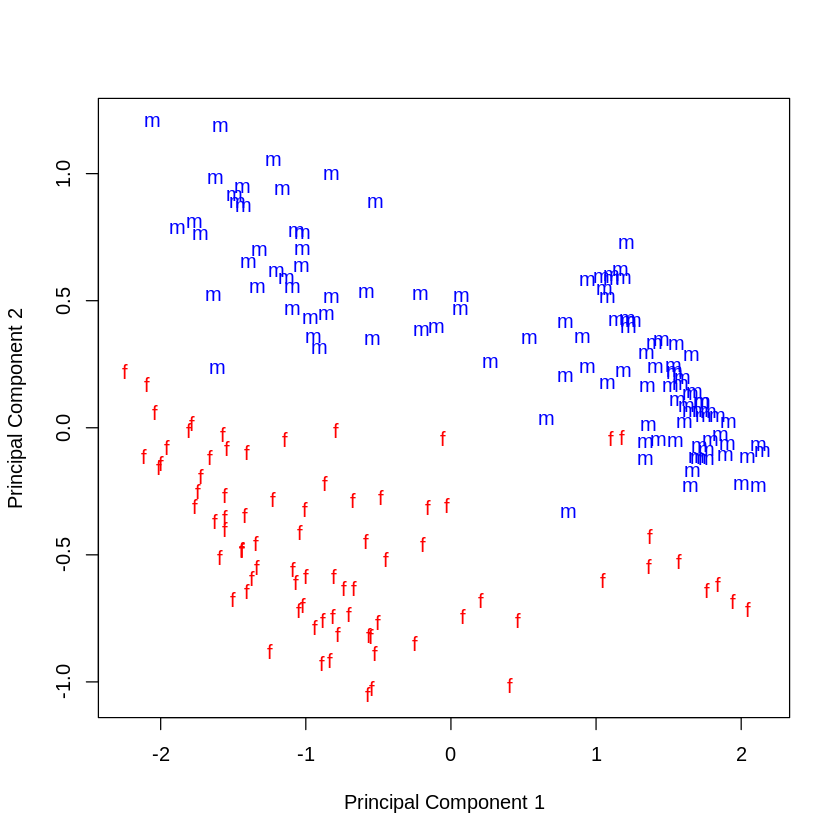

In [11]:
sex       <- factor(reduced.meta.data$sex,levels=c('male','female'))
design    <- model.matrix(~ sex)
y <- DGEList(counts=sjc, group = sex)
y <- calcNormFactors(y, method="upperquartile")

sex       <- factor(reduced.meta.data$sex,levels=c('male','female'))

design    <- model.matrix ( ~ sex)

y_voom <- voom (y, design=design, plot = TRUE)

Gender <- substring(sex,1,1)

plotMDS(y, labels=Gender, top=250, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y_voom, labels=Gender, top=250, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y, labels=Gender, top=600, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
plotMDS(y_voom, labels=Gender, top=600, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")


### SJC Plots saved as PDFs

In [12]:
pdf("../pdf/BreastMammaryTissue_sjc_voom.pdf")
y_voom <- voom (y, design=design, plot = TRUE, save.plot = TRUE)
dev.off()

Gender <- substring(sex,1,1)

pdf("../pdf/BreastMammaryTissue_sjc_MDSplot_top250.pdf")
plotMDS(y, labels=Gender, top=250, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
dev.off()

pdf("../pdf/BreastMammaryTissue_sjc_voom_MDSplot_top250.pdf")
plotMDS(y_voom, labels=Gender, top=250, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
dev.off()


pdf("../pdf/BreastMammaryTissue_sjc_MDSplot_top600.pdf")
plotMDS(y, labels=Gender, top=600, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
dev.off()

pdf("../pdf/BreastMammaryTissue_sjc_voom_MDSplot_top600.pdf")
plotMDS(y_voom, labels=Gender, top=600, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
dev.off()


png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

## Differential analysis as_event:ijc 

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + epsilon (error)
           

where y is the included exon junction count expression; sex denotes the reported sex of the subject.

[1] 42611   191

sex
female   male 
    81    110 

,intercept,sex
1,1,0
2,1,0
3,1,0
4,1,0
5,1,1
6,1,1


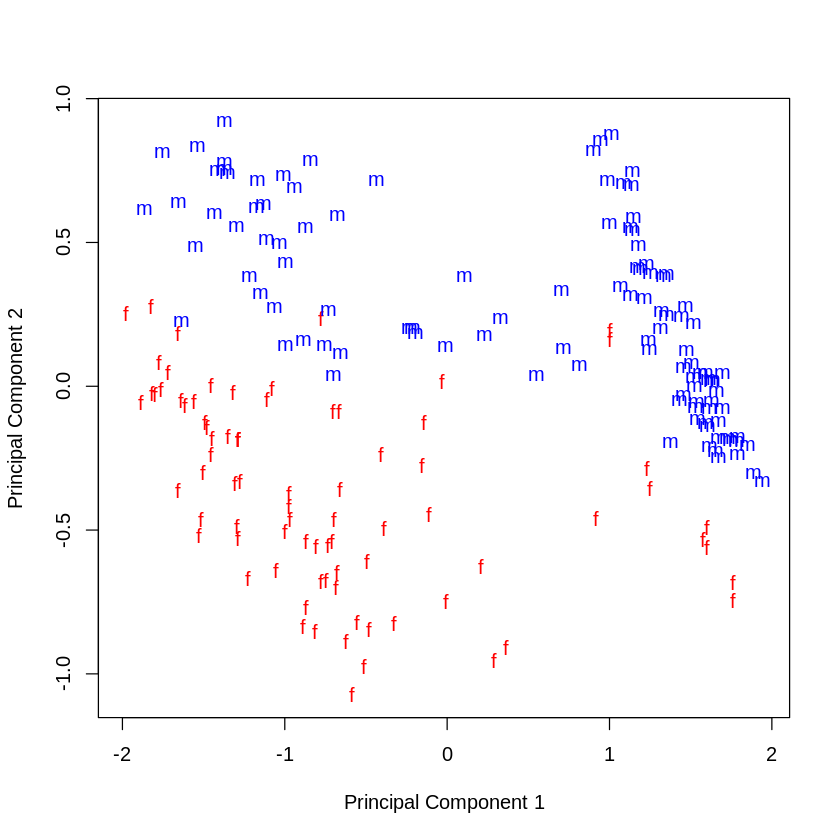

ijc_sex_results_refined
FALSE  TRUE 
42208   403 

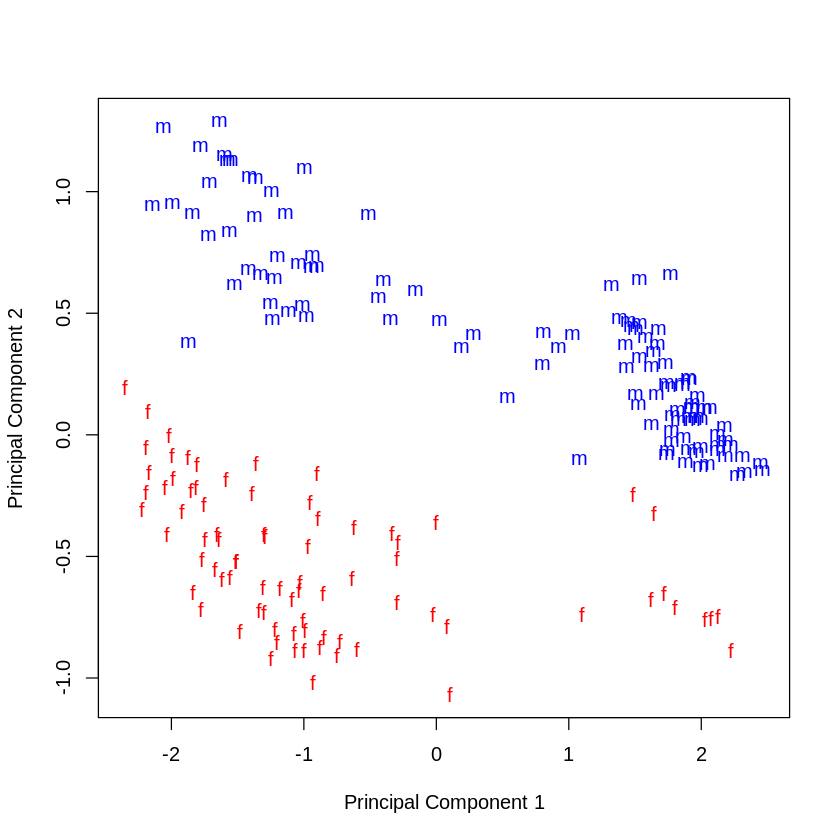

In [13]:
sex       <- reduced.meta.data$sex

design    <- model.matrix( ~ sex )

colnames(design) <- c("intercept","sex")

dim(ijc)
table(sex)
head(design)

y_ijc <- DGEList(counts=ijc, group = sex)
y_ijc <- calcNormFactors(y_ijc, method="upperquartile")

y_ijc_voom <- voom (y_ijc, design=design)

Gender <- substring(sex,1,1)

plotMDS(y_ijc, labels=Gender, top=1000, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

plotMDS(y_ijc_voom, labels=Gender, top=1000, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

fit_ijc <- lmFit(y_ijc_voom, design)
fit_ijc <- eBayes(fit_ijc)

ijc_sex_results          <- topTable(fit_ijc, coef='sex', number=nrow(y_voom))
ijc_sex_results_refined  <- ijc_sex_results$adj.P.Val < 0.05 & abs(ijc_sex_results$logFC) > 1.5

table(ijc_sex_results_refined)

## Differential analysis as_event:sjc 

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + epsilon (error)
           

where y is the excluded exon junction count (sjc) expression; sex denotes the reported sex of the subject.

[1] 42611   191

sex
female   male 
    81    110 

,intercept,sex
1,1,0
2,1,0
3,1,0
4,1,0
5,1,1
6,1,1


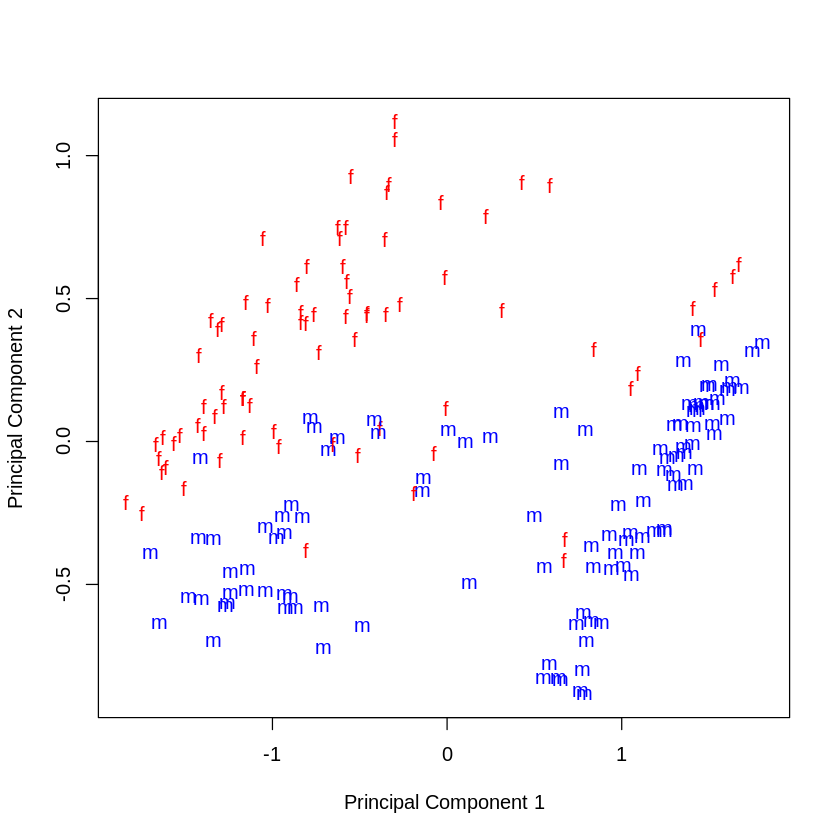

sjc_sex_results_refined
FALSE  TRUE 
42444   167 

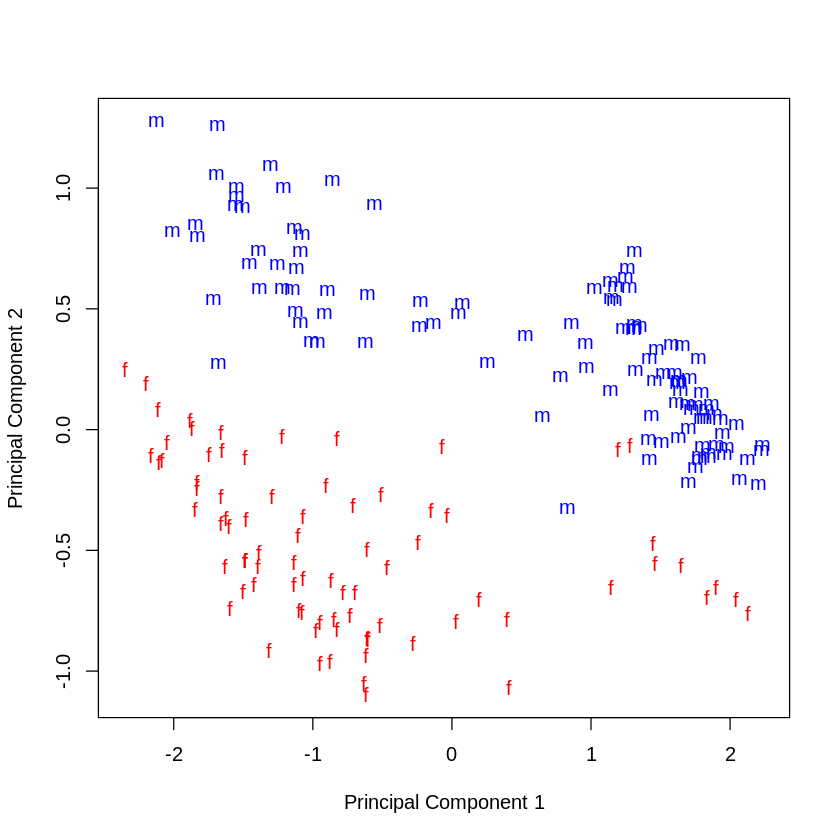

In [14]:
sex       <- reduced.meta.data$sex

design    <- model.matrix( ~ sex )

colnames(design) <- c("intercept","sex")

dim(sjc)
table(sex)
head(design)

y_sjc <- DGEList(counts=sjc, group = sex)
y_sjc <- calcNormFactors(y_sjc, method="upperquartile")

y_sjc_voom <- voom (y_sjc, design=design)

Gender <- substring(sex,1,1)

plotMDS(y_sjc, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

plotMDS(y_sjc_voom, labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

fit_sjc <- lmFit(y_sjc_voom, design)
fit_sjc <- eBayes(fit_sjc)

sjc_sex_results          <- topTable(fit_sjc, coef='sex', number=nrow(y_voom))
sjc_sex_results_refined  <- sjc_sex_results$adj.P.Val < 0.05 & abs(sjc_sex_results$logFC) > 1.5

table(sjc_sex_results_refined)

## Differential analysis as_event (combined ijc and sjc)

Differential Analysis (DE) was performed using voom (Law et.al., 2014) to transform junction counts (reads that were aligned to junctions when an exon is included - ijc, and reads that were aligned to junctions when the exon is excluded - sjc) with associated precision weights, followed by linear modeling and empirical Bayes procedure using limma.    In each tissue, the following linear regression model was used to detec secually dimorphic alternative splicing event expression: 

           y = B0 + B1 sex + B2 as_event + B3 sex*as_event + epsilon (error)
           
         alt_y = B0 + B1 sample + B2 sex + B3 as_event + B4 sex*as_event + epsilon (error)

where y is the alternative splicing event expression; sex denotes the reported sex of the subject, as_event represents the specific alternative splicing event - either included exon junction counts or skipped exon junction counts and their interaction terms.  Modeling the donor and tissue effect as a random effect, for simplicity, we call this sample.


In [15]:
sample    <- c(rep(colnames(ijc.iso.counts.mem2),2))

ijc_names <- as.character(colnames(ijc))
sjc_names <- as.character(colnames(sjc))
ijc_names <- paste0(ijc_names,"-ijc")
sjc_names <- paste0(sjc_names,"-sjc")
colnames(ijc) <- ijc_names
colnames(sjc) <- sjc_names

as_matrix <- cbind(ijc,sjc)

sex       <- c(rep(reduced.meta.data$sex,2))
sex       <- factor(sex, levels=c('male','female'))

as_event  <- c(rep("ijc",dim(ijc)[2]), rep("sjc", dim(sjc)[2]))
as_event  <- factor(as_event, levels=c("ijc", "sjc"))

# in this design, we are modeling sample as a random effect - but we could also model it in the design
design    <- model.matrix( ~ sex + as_event + sex*as_event)

colnames(design) <- c("intercept","sex","as_event","sex*as_event")

length(sample)
dim(as_matrix)
table(sex)
table(as_event)
head(design)


[1] 382

[1] 42611   382

sex
  male female 
   220    162 

as_event
ijc sjc 
191 191 

,intercept,sex,as_event,sex*as_event
1,1,1,0,0
2,1,1,0,0
3,1,1,0,0
4,1,1,0,0
5,1,0,0,0
6,1,0,0,0


### Voom, limma's lmFit and eBayes

The final factor to model is to capture the impact of the sample (which is a combination of the donor and the tissue - in this single tissue analysis -- it is just the donor) - given that we have so many 

In [48]:
y <- DGEList(counts=as_matrix, group = sex)
y <- calcNormFactors(y, method="upperquartile")
y_no_dup_voom <- voom (y, design=design)

In [18]:
dup_cor <- duplicateCorrelation(y_no_dup_voom$E, design=design, ndups=2, block=sample, weights=y$samples$norm.factors)
dup_cor$consensus.correlation

[1] 0.1859776

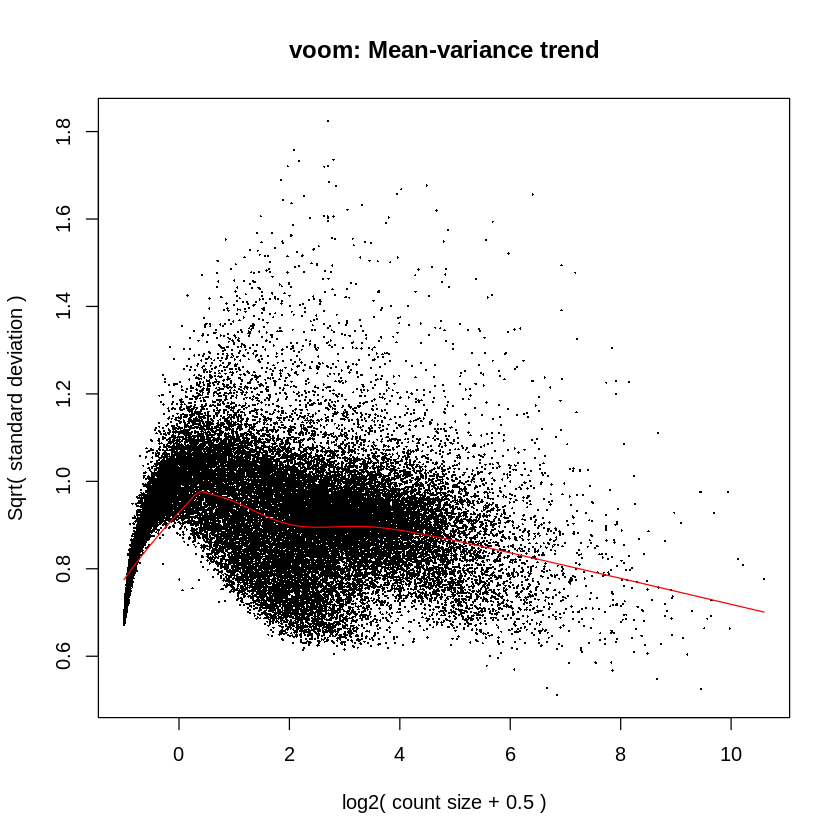

In [19]:
y_dup_voom <- voom (y, design=design, plot = TRUE, correlation = dup_cor$consensus_correlation)

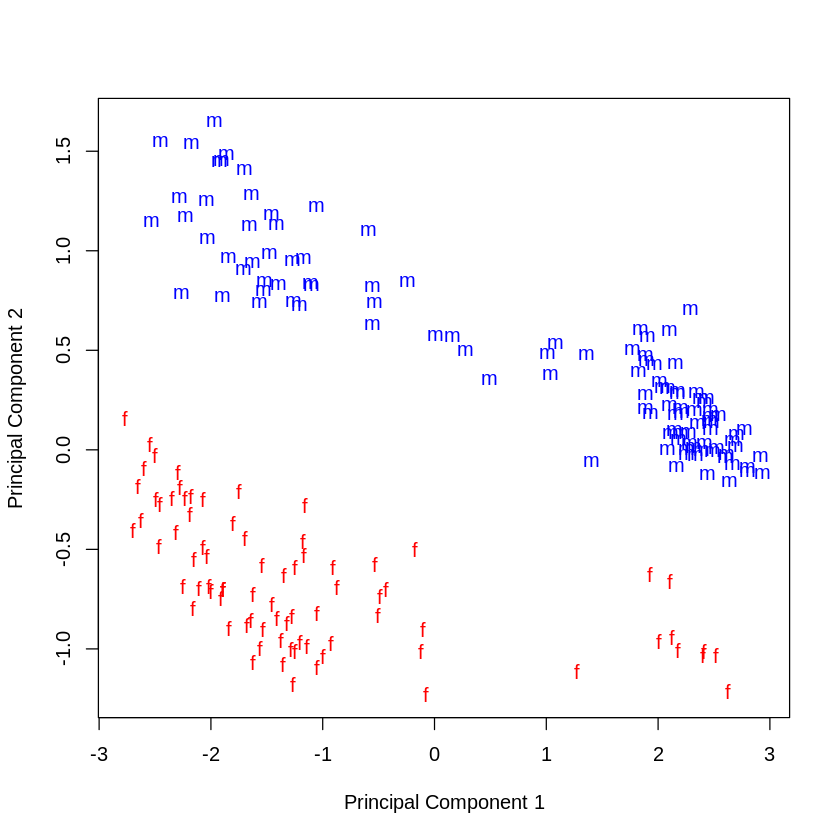

In [20]:
Gender <- substring(sex[1:191],1,1)

plotMDS(y_no_dup_voom[,c(1:191)], labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

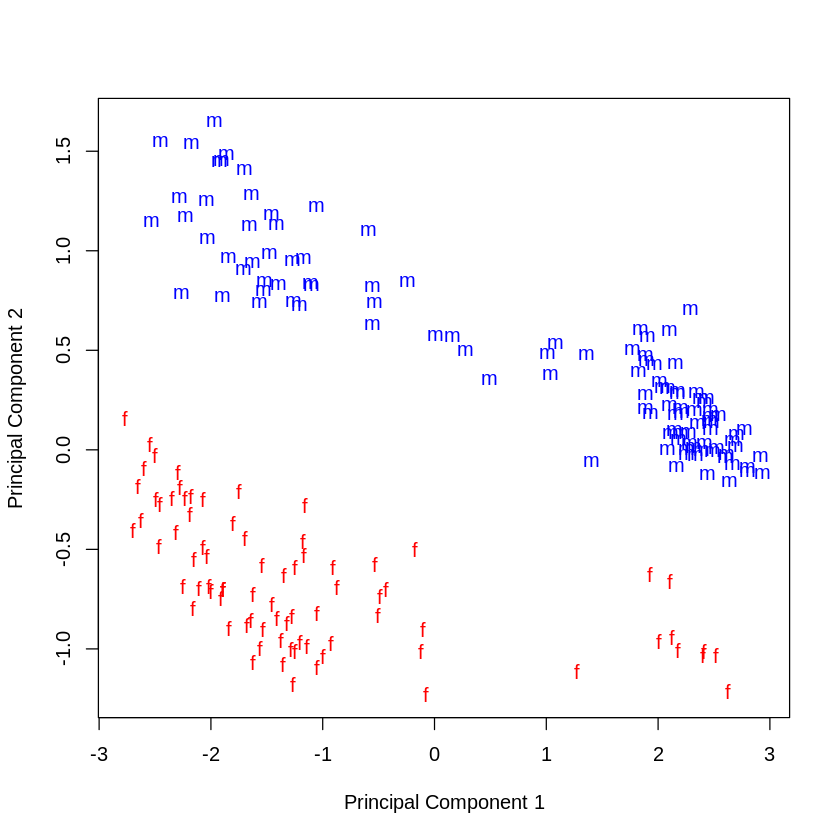

In [21]:
plotMDS(y_dup_voom[,c(1:191)], labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")

In [22]:
pdf ("../pdf/BreastMammaryTissue_y_no_dup_voom_top_500.pdf")
plotMDS(y_no_dup_voom[,c(1:191)], labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
dev.off()
pdf ("../pdf/BreastMammaryTissue_y_dup_voom_top_500.pdf")
plotMDS(y_dup_voom[,c(1:191)], labels=Gender, top=500, col=ifelse(Gender=="m","blue","red"), 
        gene.selection="common")
dev.off()

png 
  2

png 
  2

### linear fit with eBayes

With a correlation of 0.19 the two measures ijc and sjc are weakly correlated per donor. Which is to be expected, as for any single donor one would expect that the inclusion of an exon would result in the increase in the inclusion junction counts (reads aligned to the junctions associated with the included exon) and not expect that that same donor would have also evidence of excluded exon (where the counts would be to the junction revealed by the exon being excluded).   However, some amount of correlation might be here because of a haplotype affect and the location being on one allele maternally inherited versions another allele paternally inherited. 

Nevertheless, we include the duplicate correlation as calculated in our analysis.

In [51]:
fit <- lmFit(y_dup_voom, design)
fit <- eBayes(fit, robust = TRUE)

In [52]:
sex_as_events_results         <- topTable(fit, coef="sex*as_event", number=nrow(y_no_dup_voom))
sex_as_events_results_refined <- sex_as_events_results$adj.P.Val < 0.05 & abs(sex_as_events_results$logFC) > 1.5

sex_results                   <- topTable(fit, coef="sex", number=nrow(y_no_dup_voom))
sex_results_refined           <- sex_results$adj.P.Val < 0.05 & abs(sex_results$logFC) > 1.5

table(sex_as_events_results_refined)
table(sex_results_refined)

sex_as_events_results_refined
FALSE  TRUE 
42202   409 

sex_results_refined
FALSE  TRUE 
42204   407 

#### fromGTF

rMATS analyzes the gtf file and determines the junctions, identifying 10 matrices in all.  The fromGTF.SE.txt contains the annotation information and we can use this information to estimate the duplicate correlation effect from counting based upon the same gene with our ijc counts.  we will use this information, to obtain the gene information.


In [53]:
ijc_sex_results          <- topTable(fit_ijc, coef='sex', number=nrow(y_ijc_voom))
sjc_sex_results          <- topTable(fit_sjc, coef='sex', number=nrow(y_sjc_voom))

In [54]:
head(ijc_sex_results)
head(sjc_sex_results)
head(sex_as_events_results)
head(sex_results)

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19070,5.779693,1.257300,88.63095,5.555877e-160,2.367415e-155,341.1244
19076,6.220433,1.489752,84.06363,1.346018e-155,2.867758e-151,333.4615
5965,6.503253,1.715117,79.99531,1.692445e-151,2.403893e-147,325.3381
34357,7.423233,2.603206,75.76449,5.072816e-147,5.403944e-143,315.2539
5962,6.567405,1.736181,75.13688,2.450116e-146,2.088038e-142,315.1739
6300,6.502729,1.702059,74.55941,1.054910e-145,7.491795e-142,313.7534


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
28712,5.562135,2.567874,72.58155,2.903955e-145,8.970487e-141,304.4130
5964,5.979020,2.961377,72.44126,4.210409e-145,8.970487e-141,303.9824
10150,-5.734200,1.996556,-68.45096,2.180397e-140,3.096963e-136,297.0707
19072,4.472121,1.872145,55.03184,1.862232e-122,1.983789e-118,257.7507
10152,-8.167109,4.162065,-49.82503,1.951151e-114,1.662810e-110,240.9678
10151,-5.724038,2.230526,-45.16315,1.264629e-106,6.735889e-103,227.4221


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19076,5.878948,0.4623452,54.31690,1.646670e-183,7.016624e-179,398.4312
5965,6.088533,0.5974117,52.39047,3.775190e-178,8.043230e-174,386.9017
19070,5.428275,0.3502684,50.17228,8.627337e-172,1.225398e-167,373.1113
5962,5.904402,0.6820468,45.76421,1.602191e-158,1.706774e-154,344.3004
6300,5.499113,0.7601863,38.96247,3.080229e-136,2.625033e-132,295.2158
34357,5.634145,1.4625119,38.17561,1.654765e-133,1.175186e-129,288.5726


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
19076,-6.235569,0.4623452,-78.81341,5.488416e-241,2.338669e-236,530.7072
10150,8.557897,2.3079804,78.54106,1.944751e-240,4.143389e-236,529.4407
5965,-6.527929,0.5974117,-77.17981,1.148858e-237,1.631800e-233,523.6118
34357,-7.471749,1.4625119,-74.92759,5.510933e-233,5.870659e-229,513.2821
19070,-5.799804,0.3502684,-72.86184,1.392000e-228,1.186290e-224,503.6406
5963,-6.714978,1.5036864,-72.52473,7.452876e-228,5.292908e-224,502.4134


In [55]:
fromGTF.SE <- read.table("../data/fromGTF.SE.txt", header=TRUE)
head(fromGTF.SE)
genes <- factor(fromGTF.SE$geneSymbol)
length(levels(genes))

,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,ENSG00000034152.18,MAP2K3,chr17,+,21287990,21288091,21284709,21284969,21295674,21295769
2,2,ENSG00000034152.18,MAP2K3,chr17,+,21303182,21303234,21302142,21302259,21304425,21304553
3,3,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21287990,21288091,21296085,21296143
4,4,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21287990,21288091,21298412,21298479
5,5,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21284710,21284969,21296085,21296143
6,6,ENSG00000034152.18,MAP2K3,chr17,+,21295674,21295769,21284710,21284969,21298412,21298479


[1] 13390

In [56]:
# index to the annotations - these are the Junction IDs
sex_as_events_rnResults <- rownames(sex_as_events_results)
sex_rnResults           <- rownames(sex_results)
ijc_sex_rnResults       <- rownames(ijc_sex_results)
sjc_sex_rnResults       <- rownames(sjc_sex_results)
head(sex_as_events_rnResults)
head(ijc_sex_rnResults)
head(sjc_sex_rnResults)
head(sex_rnResults)
head(fromGTF.SE[sex_as_events_rnResults,])

[1] "19076" "5965"  "19070" "5962"  "6300"  "34357"

[1] "19070" "19076" "5965"  "34357" "5962"  "6300"

[1] "28712" "5964"  "10150" "19072" "10152" "10151"

[1] "19076" "10150" "5965"  "34357" "19070" "5963"

,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
19076,19076,ENSG00000183878.15,UTY,chrY,-,13306037,13306112,13305398,13305547,13306185,13306250
5965,5965,ENSG00000012817.15,KDM5D,chrY,-,19741317,19741488,19739527,19739662,19741734,19741857
19070,19070,ENSG00000183878.15,UTY,chrY,-,13251016,13251187,13248378,13249882,13260277,13260404
5962,5962,ENSG00000012817.15,KDM5D,chrY,-,19741734,19741857,19741317,19741488,19743161,19743239
6300,6300,ENSG00000114374.13,USP9Y,chrY,+,12847238,12847327,12846932,12847153,12856339,12856496
34357,34357,ENSG00000198692.10,EIF1AY,chrY,+,20584473,20584524,20582589,20582693,20588023,20588105


In [57]:
# use the junctionIDs to get the annotations
sex_as_events_resultsAnnotations      <- fromGTF.SE[sex_as_events_rnResults,]
sex_resultsAnnotations                <- fromGTF.SE[sex_rnResults,]
ijc_sex_resultsAnnotations            <- fromGTF.SE[ijc_sex_rnResults,]
sjc_sex_resultsAnnotations            <- fromGTF.SE[sjc_sex_rnResults,]
head(sex_as_events_resultsAnnotations)
head(sex_resultsAnnotations)
head(ijc_sex_resultsAnnotations)
head(sjc_sex_resultsAnnotations)

,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
19076,19076,ENSG00000183878.15,UTY,chrY,-,13306037,13306112,13305398,13305547,13306185,13306250
5965,5965,ENSG00000012817.15,KDM5D,chrY,-,19741317,19741488,19739527,19739662,19741734,19741857
19070,19070,ENSG00000183878.15,UTY,chrY,-,13251016,13251187,13248378,13249882,13260277,13260404
5962,5962,ENSG00000012817.15,KDM5D,chrY,-,19741734,19741857,19741317,19741488,19743161,19743239
6300,6300,ENSG00000114374.13,USP9Y,chrY,+,12847238,12847327,12846932,12847153,12856339,12856496
34357,34357,ENSG00000198692.10,EIF1AY,chrY,+,20584473,20584524,20582589,20582693,20588023,20588105


,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
19076,19076,ENSG00000183878.15,UTY,chrY,-,13306037,13306112,13305398,13305547,13306185,13306250
10150,10150,ENSG00000229807.11,XIST,chrX,-,73833237,73833374,73831065,73831274,73837439,73841474
5965,5965,ENSG00000012817.15,KDM5D,chrY,-,19741317,19741488,19739527,19739662,19741734,19741857
34357,34357,ENSG00000198692.10,EIF1AY,chrY,+,20584473,20584524,20582589,20582693,20588023,20588105
19070,19070,ENSG00000183878.15,UTY,chrY,-,13251016,13251187,13248378,13249882,13260277,13260404
5963,5963,ENSG00000012817.15,KDM5D,chrY,-,19739527,19739662,19735620,19735750,19741317,19741488


,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
19070,19070,ENSG00000183878.15,UTY,chrY,-,13251016,13251187,13248378,13249882,13260277,13260404
19076,19076,ENSG00000183878.15,UTY,chrY,-,13306037,13306112,13305398,13305547,13306185,13306250
5965,5965,ENSG00000012817.15,KDM5D,chrY,-,19741317,19741488,19739527,19739662,19741734,19741857
34357,34357,ENSG00000198692.10,EIF1AY,chrY,+,20584473,20584524,20582589,20582693,20588023,20588105
5962,5962,ENSG00000012817.15,KDM5D,chrY,-,19741734,19741857,19741317,19741488,19743161,19743239
6300,6300,ENSG00000114374.13,USP9Y,chrY,+,12847238,12847327,12846932,12847153,12856339,12856496


,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
28712,28712,ENSG00000131002.12,TXLNGY,chrY,+,19598551,19598639,19597356,19597665,19599738,19599831
5964,5964,ENSG00000012817.15,KDM5D,chrY,-,19723340,19723433,19721129,19721311,19731771,19731930
10150,10150,ENSG00000229807.11,XIST,chrX,-,73833237,73833374,73831065,73831274,73837439,73841474
19072,19072,ENSG00000183878.15,UTY,chrY,-,13354785,13354833,13335562,13336335,13355002,13355398
10152,10152,ENSG00000229807.11,XIST,chrX,-,73830622,73830790,73829067,73829231,73831065,73831210
10151,10151,ENSG00000229807.11,XIST,chrX,-,73822070,73822233,73820655,73821029,73826114,73826301


In [58]:
sex_as_events_results_refinedAnnotations<- sex_as_events_resultsAnnotations[sex_as_events_results_refined==TRUE,]
sex_results_refinedAnnotations          <- sex_resultsAnnotations          [sex_results_refined          ==TRUE,]
ijc_sex_results_refinedAnnotations      <- ijc_sex_resultsAnnotations      [ijc_sex_results_refined      ==TRUE,]
sjc_sex_results_refinedAnnotations      <- sjc_sex_resultsAnnotations      [sjc_sex_results_refined      ==TRUE,]
head(sex_as_events_results_refinedAnnotations)
head(sex_results_refinedAnnotations)
head(ijc_sex_results_refinedAnnotations)
head(sjc_sex_results_refinedAnnotations)

,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
19076,19076,ENSG00000183878.15,UTY,chrY,-,13306037,13306112,13305398,13305547,13306185,13306250
5965,5965,ENSG00000012817.15,KDM5D,chrY,-,19741317,19741488,19739527,19739662,19741734,19741857
19070,19070,ENSG00000183878.15,UTY,chrY,-,13251016,13251187,13248378,13249882,13260277,13260404
5962,5962,ENSG00000012817.15,KDM5D,chrY,-,19741734,19741857,19741317,19741488,19743161,19743239
6300,6300,ENSG00000114374.13,USP9Y,chrY,+,12847238,12847327,12846932,12847153,12856339,12856496
34357,34357,ENSG00000198692.10,EIF1AY,chrY,+,20584473,20584524,20582589,20582693,20588023,20588105


,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
19076,19076,ENSG00000183878.15,UTY,chrY,-,13306037,13306112,13305398,13305547,13306185,13306250
10150,10150,ENSG00000229807.11,XIST,chrX,-,73833237,73833374,73831065,73831274,73837439,73841474
5965,5965,ENSG00000012817.15,KDM5D,chrY,-,19741317,19741488,19739527,19739662,19741734,19741857
34357,34357,ENSG00000198692.10,EIF1AY,chrY,+,20584473,20584524,20582589,20582693,20588023,20588105
19070,19070,ENSG00000183878.15,UTY,chrY,-,13251016,13251187,13248378,13249882,13260277,13260404
5963,5963,ENSG00000012817.15,KDM5D,chrY,-,19739527,19739662,19735620,19735750,19741317,19741488


,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
19070,19070,ENSG00000183878.15,UTY,chrY,-,13251016,13251187,13248378,13249882,13260277,13260404
19076,19076,ENSG00000183878.15,UTY,chrY,-,13306037,13306112,13305398,13305547,13306185,13306250
5965,5965,ENSG00000012817.15,KDM5D,chrY,-,19741317,19741488,19739527,19739662,19741734,19741857
34357,34357,ENSG00000198692.10,EIF1AY,chrY,+,20584473,20584524,20582589,20582693,20588023,20588105
5962,5962,ENSG00000012817.15,KDM5D,chrY,-,19741734,19741857,19741317,19741488,19743161,19743239
6300,6300,ENSG00000114374.13,USP9Y,chrY,+,12847238,12847327,12846932,12847153,12856339,12856496


,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,downstreamES,downstreamEE
,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<int>,<int>,<int>,<int>,<int>
28712,28712,ENSG00000131002.12,TXLNGY,chrY,+,19598551,19598639,19597356,19597665,19599738,19599831
5964,5964,ENSG00000012817.15,KDM5D,chrY,-,19723340,19723433,19721129,19721311,19731771,19731930
10150,10150,ENSG00000229807.11,XIST,chrX,-,73833237,73833374,73831065,73831274,73837439,73841474
19072,19072,ENSG00000183878.15,UTY,chrY,-,13354785,13354833,13335562,13336335,13355002,13355398
10152,10152,ENSG00000229807.11,XIST,chrX,-,73830622,73830790,73829067,73829231,73831065,73831210
10151,10151,ENSG00000229807.11,XIST,chrX,-,73822070,73822233,73820655,73821029,73826114,73826301


In [59]:

# geneSymbols are in the annotations
sex_as_events_geneSymbols         <- sex_as_events_resultsAnnotations$geneSymbol
sex_geneSymbols                   <- sex_resultsAnnotations$geneSymbol
ijc_sex_geneSymbols               <- ijc_sex_resultsAnnotations$geneSymbol
sjc_sex_geneSymbols               <- sjc_sex_resultsAnnotations$geneSymbol

sex_as_events_refined_geneSymbols <- sex_as_events_results_refinedAnnotations$geneSymbol
sex_refined_geneSymbols           <- sex_results_refinedAnnotations$geneSymbol
ijc_sex_refined_geneSymbols       <- ijc_sex_results_refinedAnnotations$geneSymbol
sjc_sex_refined_geneSymbols       <- sjc_sex_results_refinedAnnotations$geneSymbol

# adjust the rownames to be the geneSymbols rather than junction IDs
sex_as_events_results_rn   <- paste(sex_as_events_geneSymbols, sex_as_events_rnResults, sep="-")
sex_results_rn             <- paste(sex_geneSymbols,           sex_rnResults, sep="-")
ijc_sex_results_rn         <- paste(ijc_sex_geneSymbols,       ijc_sex_rnResults, sep="-")
sjc_sex_results_rn         <- paste(sjc_sex_geneSymbols,       sjc_sex_rnResults, sep="-")

head(sex_as_events_results_rn)
head(sex_results_rn)
head(ijc_sex_results_rn)
head(sjc_sex_results_rn)


[1] "UTY-19076"    "KDM5D-5965"   "UTY-19070"    "KDM5D-5962"   "USP9Y-6300"  
[6] "EIF1AY-34357"

[1] "UTY-19076"    "XIST-10150"   "KDM5D-5965"   "EIF1AY-34357" "UTY-19070"   
[6] "KDM5D-5963"

[1] "UTY-19070"    "UTY-19076"    "KDM5D-5965"   "EIF1AY-34357" "KDM5D-5962"  
[6] "USP9Y-6300"

[1] "TXLNGY-28712" "KDM5D-5964"   "XIST-10150"   "UTY-19072"    "XIST-10152"  
[6] "XIST-10151"

In [60]:
rownames(sex_as_events_results) <- sex_as_events_results_rn
rownames(sex_results)           <- sex_results_rn
rownames(ijc_sex_results)       <- ijc_sex_results_rn
rownames(sjc_sex_results)       <- sjc_sex_results_rn

In [61]:
sex_as_events_filename         = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_sex_as_events.csv',sep='')
sex_filename                   = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_sex.csv',sep='')
ijc_sex_filename               = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_ijc_sex.csv',sep='')
sjc_sex_filename               = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_sjc_sex.csv',sep='')

sex_as_events_refined_filename = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_sex_as_events_refined.csv',sep='')
sex_refined_filename           = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_sex_refined.csv',sep='')
ijc_sex_refined_filename       = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_ijc_sex_refined.csv',sep='')
sjc_sex_refined_filename       = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_DGE_sjc_sex_refined.csv',sep='')

sex_as_events_genesFilename    = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_sex_as_events_universe.txt',sep='')
sex_genesFilename              = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_sex_universe.txt',sep='')
ijc_sex_genesFilename          = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_ijc_sex_universe.txt',sep='')
sjc_sex_genesFilename          = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_sjc_sex_universe.txt',sep='')

sex_as_events_refined_genesFilename = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_sex_as_events_gene_set.txt',sep='')
sex_refined_genesFilename           = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_sex_gene_set.txt',sep='')
ijc_sex_refined_genesFilename       = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_ijc_sex_gene_set.txt',sep='')
sjc_sex_refined_genesFilename       = paste(paste('../data/BreastMammaryTissue',collapse='.'),'_sjc_sex_gene_set.txt',sep='')


In [62]:
write.table(sex_as_events_results, file = sex_as_events_filename, row.names = T, col.names = T, quote = F, sep = ",")
write.table(sex_results,           file = sex_filename          , row.names = T, col.names = T, quote = F, sep = ",")
write.table(ijc_sex_results,       file = ijc_sex_filename      , row.names = T, col.names = T, quote = F, sep = ",")
write.table(sjc_sex_results,       file = sjc_sex_filename      , row.names = T, col.names = T, quote = F, sep = ",")

write.table(sex_as_events_results[sex_as_events_results_refined,], file = sex_as_events_refined_filename, row.names = T, col.names = T, quote = F, sep = ",")
write.table(sex_results          [sex_results_refined          ,], file = sex_refined_filename          , row.names = T, col.names = T, quote = F, sep = ",")
write.table(ijc_sex_results      [ijc_sex_results_refined      ,], file = ijc_sex_refined_filename      , row.names = T, col.names = T, quote = F, sep = ",")
write.table(sjc_sex_results      [sjc_sex_results_refined      ,], file = sjc_sex_refined_filename      , row.names = T, col.names = T, quote = F, sep = ",")

write.table(sex_as_events_geneSymbols, file = sex_as_events_genesFilename, row.names = F, col.names = F, quote = F, sep = ",")
write.table(sex_geneSymbols,           file = sex_genesFilename          , row.names = F, col.names = F, quote = F, sep = ",")
write.table(ijc_sex_geneSymbols,       file = ijc_sex_genesFilename      , row.names = F, col.names = F, quote = F, sep = ",")
write.table(sjc_sex_geneSymbols,       file = sjc_sex_genesFilename      , row.names = F, col.names = F, quote = F, sep = ",")

write.table(sex_as_events_refined_geneSymbols,file = sex_as_events_refined_genesFilename, row.names = F, col.names = F, quote = F, sep = ",")
write.table(sex_refined_geneSymbols,          file = sex_refined_genesFilename          , row.names = F, col.names = F, quote = F, sep = ",")
write.table(ijc_sex_refined_geneSymbols,      file = ijc_sex_refined_genesFilename      , row.names = F, col.names = F, quote = F, sep = ",")
write.table(sjc_sex_refined_geneSymbols,      file = sjc_sex_refined_genesFilename      , row.names = F, col.names = F, quote = F, sep = ",")


## Metadata

For replicability and reproducibility purposes, we also print the following metadata:

1. Checksums of **'artefacts'**, files generated during the analysis and stored in the folder directory **`data`**
2. List of environment metadata, dependencies, versions of libraries using `utils::sessionInfo()` and [`devtools::session_info()`](https://devtools.r-lib.org/reference/session_info.html)

### 1. Checksums with the sha256 algorithm

In [63]:
notebookid   = "BreastMammaryTissueJunctionAnalysis"

message("Generating sha256 checksums of the artefacts in the `..data/` directory .. ")
system(paste0("cd ../data && find . -type f -exec sha256sum {} \\;  >  ../metadata/", notebookid, "_sha256sums.txt"), intern = TRUE)
message("Done!\n")

data.table::fread(paste0("../metadata/", notebookid, "_sha256sums.txt"), header = FALSE, col.names = c("sha256sum", "file"))

Generating sha256 checksums of the artefacts in the `..data/` directory .. 


character(0)

Done!

Warning message in data.table::fread(paste0("../metadata/", notebookid, "_sha256sums.txt"), :
“Stopped early on line 7. Expected 2 fields but found 5. Consider fill=TRUE and comment.char=. First discarded non-empty line: <<f117a76a29a921bea1c77bebafaa6a94e294a00e9da740daf8e12c7c5c4ddc3b  ./.ipynb_checkpoints/Breast - Mammary Tissue-anno-gene_set-Term-For-Term-Benjamini-Hochberg-checkpoint.txt>>”

sha256sum,file
<chr>,<chr>
d03c22e998eae9c96ab6e07340266fdff0d8f4f896fe7bd62ab80bb5aa7857f1,./BreastMammaryTissue_DGE_ijc_sex.csv
ebe1713963cd88e7bb2ac961e7d7209b38d2b0e8136b28fe4425ac8d04ad0b18,./rmats_final.mxe.jcec.skiplen.txt.gz
bb6bbb4eea3f0533b49b3c3f36d94aa66d54fe3e6e8ac0e105badab6cbf8538a,./BreastMammaryTissue_sex_as_events_universe.txt
490afac0f9797126ea051b167f409bbc011a8bdbe190b991ce0da972c5424cbf,./Cells-EBV-transformedlymphocytes_DGE.csv
38307c2edf8434a57dc1113575887aafd735a529412046ba10f46c716fedcd2f,./Brain-CerebellarHemisphere_DGE.csv
b8347e8cd7fc16b23041a2809aa38e1590813c8858c6a2aa14f8fc4c134fba3e,"./.ipynb_checkpoints/BreastMammaryTissue,.DGE_isoforms_robust-checkpoint.csv"


### 2. Libraries metadata

In [64]:
dev_session_info   <- devtools::session_info()
utils_session_info <- utils::sessionInfo()

message("Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..")
saveRDS(dev_session_info, file = paste0("../metadata/", notebookid, "_devtools_session_info.rds"))
message("Done!\n")

message("Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..")
saveRDS(utils_session_info, file = paste0("../metadata/", notebookid ,"_utils_info.rds"))
message("Done!\n")

dev_session_info$platform
dev_session_info$packages[dev_session_info$packages$attached==TRUE, ]

Saving `devtools::session_info()` objects in ../metadata/devtools_session_info.rds  ..
Done!

Saving `utils::sessionInfo()` objects in ../metadata/utils_session_info.rds  ..
Done!



 setting  value                       
 version  R version 3.6.1 (2019-07-05)
 os       Ubuntu 18.04.3 LTS          
 system   x86_64, linux-gnu           
 ui       X11                         
 language en_US.UTF-8                 
 collate  en_US.UTF-8                 
 ctype    en_US.UTF-8                 
 tz       Etc/UTC                     
 date     2020-05-12                  

,package,ondiskversion,loadedversion,path,loadedpath,attached,is_base,date,source,md5ok,library
,<chr>,<chr>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<lgl>,<fct>
Biobase,Biobase,2.46.0,2.46.0,/opt/conda/lib/R/library/Biobase,/opt/conda/lib/R/library/Biobase,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
BiocGenerics,BiocGenerics,0.32.0,0.32.0,/opt/conda/lib/R/library/BiocGenerics,/opt/conda/lib/R/library/BiocGenerics,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
edgeR,edgeR,3.28.1,3.28.1,/opt/conda/lib/R/library/edgeR,/opt/conda/lib/R/library/edgeR,TRUE,FALSE,2020-02-26,Bioconductor,NA,/opt/conda/lib/R/library
limma,limma,3.42.0,3.42.0,/opt/conda/lib/R/library/limma,/opt/conda/lib/R/library/limma,TRUE,FALSE,2019-10-29,Bioconductor,NA,/opt/conda/lib/R/library
multtest,multtest,2.40.0,2.40.0,/opt/conda/lib/R/library/multtest,/opt/conda/lib/R/library/multtest,TRUE,FALSE,2019-05-02,Bioconductor,NA,/opt/conda/lib/R/library
R.methodsS3,R.methodsS3,1.8.0,1.8.0,/opt/conda/lib/R/library/R.methodsS3,/opt/conda/lib/R/library/R.methodsS3,TRUE,FALSE,2020-02-14,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
R.oo,R.oo,1.23.0,1.23.0,/opt/conda/lib/R/library/R.oo,/opt/conda/lib/R/library/R.oo,TRUE,FALSE,2019-11-03,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
R.utils,R.utils,2.9.2,2.9.2,/opt/conda/lib/R/library/R.utils,/opt/conda/lib/R/library/R.utils,TRUE,FALSE,2019-12-08,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
tibble,tibble,2.1.3,2.1.3,/opt/conda/lib/R/library/tibble,/opt/conda/lib/R/library/tibble,TRUE,FALSE,2019-06-06,CRAN (R 3.6.1),NA,/opt/conda/lib/R/library
